In [176]:
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_num_snaps import get_num_snaps
from read_simulation_data.get_info import get_info
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import os
import visualize_background as vb
import astropy.units as u
from matplotlib.colors import Normalize

import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib.animation import FuncAnimation


from plot_simulation_data.plot_foreground_variable_2D import plot_foreground_variable_2D
from plot_simulation_data.plot_foreground_variable_1D import plot_foreground_variable_1D
from plot_simulation_data.plot_all_foreground_variables_2D import plot_all_foreground_variables_2D
from plot_simulation_data.plot_all_foreground_variables_1D import plot_all_foreground_variables_1D
from plot_simulation_data.animate_all_foreground_variables_1D import animate_all_foreground_variables_1D
from plot_simulation_data.animate_all_foreground_variables_2D import animate_all_foreground_variables_2D
from plot_simulation_data.plot_foreground_variable_cross_section_3D import plot_foreground_variable_cross_section_3D
from plot_simulation_data.plot_all_foreground_variables_cross_section_3D import plot_all_foreground_variables_cross_section_3D
from plot_simulation_data.animate_all_foreground_variables_across_axis_3D import animate_all_foreground_variables_across_axis_3D

from plot_simulation_data.plot_conservation_of_mass_2D import plot_conservation_of_mass_2D

DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
R_SUN = 6.957e10

In [43]:
def compute_advective_term(v, dz, dy):
    z_component = v[0]*np.gradient(v[0], dz, axis=0) + v[1]*np.gradient(v[0], dy, axis=1)
    y_component = v[0]*np.gradient(v[1], dz, axis=0) + v[1]*np.gradient(v[1], dy, axis=1)

    return np.stack((z_component, y_component), axis=0)

def compute_diffusive_term(v, dz, dy, mu):
    dvz_dz = np.gradient(v[0], dz, axis=0)
    dvz_dy = np.gradient(v[0], dy, axis=1)
    dvy_dz = np.gradient(v[1], dz, axis=0)
    dvy_dy = np.gradient(v[1], dy, axis=1)

    ddvz_ddz = np.gradient(dvz_dz, dz, axis=0)
    ddvz_ddy = np.gradient(dvz_dy, dy, axis=1)
    ddvy_ddy = np.gradient(dvy_dy, dy, axis=1)
    ddvy_ddz = np.gradient(dvy_dz, dz, axis=0)

    ddvz_dzdy = np.gradient(dvz_dz, dy, axis=1)
    ddvy_dzdy = np.gradient(dvy_dz, dy, axis=1)

    z_component = 4/3 * ddvz_ddz + 1/3 * ddvy_dzdy + ddvz_ddy
    y_component = 4/3 * ddvy_ddy + 1/3 * ddvz_dzdy + ddvy_ddz

    z_component *= mu
    y_component *= mu

    return np.stack((z_component, y_component), axis=0)

def compute_mu(v, dz, dy):
    mu0 = 1.0e6 * u.Unit("P")
    mu1 = 1.0e15 * u.Unit("P s")

    dvz_dz = np.gradient(v[0], dz, axis=0)
    dvy_dy = np.gradient(v[1], dy, axis=1)

    return mu0 + mu1*np.sqrt(dvy_dy*dvy_dy + dvz_dz*dvz_dz)

In [45]:
def compute_gradient(field, dz, dy):
    # Compute the gradient along each direction
    # The axis order is specified to ensure compatibility with the output shape requirement
    grad_z, grad_y = np.gradient(field, dz, dy, edge_order=2)
    
    # Stack the gradients to get the desired output shape
    gradient = np.stack((grad_z, grad_y), axis=0)
    
    return gradient

In [51]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2)

In [175]:
def plot_diffusion_term_2D(folder, ax1, ax2, ax3, snap_number, **kwargs):
    # Get the foreground variable and time
    _, global_parameters, grid_info = get_info(folder)

    y0 = 0.0
    y1 = global_parameters['Y_SIZE'][0]*R_SUN
    z0 = global_parameters['R_START'][0]*R_SUN
    z1 = global_parameters['R_END'][0]*R_SUN

    p1, unit, t = get_foreground_variable(folder, snap_number, "p1")
    p1 = p1 * u.Unit(unit)
    vz, unit, _ = get_foreground_variable(folder, snap_number, "vz")
    vz = vz * u.Unit(unit)
    vy, unit, _ = get_foreground_variable(folder, snap_number, "vy")
    vy = vy * u.Unit(unit)
    rho1, unit, _ = get_foreground_variable(folder, snap_number, "rho1")
    rho1 = rho1 * u.Unit(unit)
    g, unit = get_background_variable(folder, "g")
    g = g * u.Unit(unit)
    rho0, unit = get_background_variable(folder, "rho0")
    rho0 = rho0 * u.Unit(unit)

    v = np.stack((vz, vy), axis=0)

    # plotting gradient of vz
    dz, unit = grid_info['dz']
    dz = dz * u.Unit(unit)
    dy, unit = grid_info['dy']
    dy = dy * u.Unit(unit)

    grad_p1_term =   1/rho0[:,np.newaxis] * compute_gradient(p1, dz, dy)
    advective_term = compute_advective_term(v, dz, dy)
    diffusive_term = 1/rho0[:,np.newaxis] * compute_diffusive_term(v, dz, dy, compute_mu(v, dz, dy))
    gravity_term_z =  rho1  * (g/rho0)[:,np.newaxis]

    diffusion_over_advection = (norm(diffusive_term / advective_term))[3:-3,1:-1]
    diffusion_over_pressure = (norm(diffusive_term / grad_p1_term))[3:-3,1:-1]
    diffusion_over_gravity = (norm(diffusive_term) / np.abs(gravity_term_z))[3:-3,1:-1]

    ax1.set_title(r"$||\nabla\cdot\Pi /\rho_0 (v\cdot\nabla)v||$")
    ax2.set_title(r"$||\nabla\cdot\Pi / \nabla p||$")
    ax3.set_title(r"$||\nabla\cdot\Pi|| / |\rho_1 g|$")

    # Handle kwargs
    if kwargs.get("cmap") == None:
        cmap = "Blues"
    else:
        cmap = kwargs.get("cmap")

    if kwargs.get("aspect") == None:
        aspect = (y1-y0)/(z1-z0) * 1.2
    else:
        aspect = kwargs.get("aspect")

    if kwargs.get("font_size") == None:
        font_size = 13
    else:
        font_size = kwargs.get("font_size")

    if kwargs.get("extent") == None:
        extent = np.array([y0,y1,z0,z1])/R_SUN
    else:
        extent = kwargs.get("extent")

    t = t*u.s
    if kwargs.get("t_scale") == None:
        t = t.to(u.hour)
    else:
        t = t.to(kwargs.get("t_scale"))   

    vmax1 = np.max(np.abs(diffusion_over_advection))
    vmax2 = np.max(np.abs(diffusion_over_pressure))
    vmax3 = np.max(np.abs(diffusion_over_gravity))

    im1 = ax1.imshow(diffusion_over_advection.value, origin="lower", extent=extent, aspect=aspect, cmap=cmap)
    im2 = ax2.imshow(diffusion_over_pressure.value, origin="lower", extent=extent, aspect=aspect, cmap=cmap)
    im3 = ax3.imshow(diffusion_over_gravity.value, origin="lower", extent=extent, aspect=aspect, cmap=cmap)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("x [Solar radii]", fontsize=font_size)
        ax.set_ylabel("z [Solar radii]", fontsize=font_size)

    return im1, im2, im3

In [173]:
def plot_diffusion_and_foreground_variables_2D(folder, fig, snap_number, **kwargs):
    # Handle kwargs
    if kwargs.get("title_size") == None:
        title_size = 15
    else:
        title_size = kwargs.get("title_size")

    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.6, hspace=0.3)

    # Order of keys for plotting
    plot_order = ["T1", "rho1", "vy", "p1", "s1", "vz"]

    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 2])
    ax3 = fig.add_subplot(gs[2, 4])

    im1, im2, im3 = plot_diffusion_term_2D(folder, ax1, ax2, ax3, snap_number, **kwargs)

    pos1 = ax1.get_position()
    cax1 = fig.add_axes([pos1.x1 + 0.01, pos1.y0, 0.01, pos1.height])
    cbar1 = plt.colorbar(im1, cax=cax1)

    pos2 = ax2.get_position()
    cax2 = fig.add_axes([pos2.x1 + 0.01, pos2.y0, 0.01, pos2.height])
    cbar2 = plt.colorbar(im2, cax=cax2)

    pos3 = ax3.get_position()
    cax3 = fig.add_axes([pos3.x1 + 0.01, pos3.y0, 0.01, pos3.height])
    cbar3 = plt.colorbar(im3, cax=cax3)

    for idx, key in enumerate(plot_order):
        i, j = divmod(idx, 3)  # Convert 1D index to 2D indices
        # Create the subplot using GridSpec indexing
        ax = fig.add_subplot(gs[i, 2*j])

        # Plot the foreground variable
        im, t = plot_foreground_variable_2D(folder, ax, snap_number, key, **kwargs)
        
        # Create a new axes for the colorbar next to the current subplot
        pos = ax.get_position()
        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
        cbar = plt.colorbar(im, cax=cax)

        # Enforce scientific notation
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-1, 1))
        cbar.ax.yaxis.set_major_formatter(formatter)

    # Title for the entire plot with the time
    fig.suptitle(f"t={t.value:.1f} [{t.unit.to_string(format='latex_inline')}]", fontsize=title_size, y=0.96)

In [179]:
def animate_all_diffusion_and_foreground_2D(folder, save=False, save_name=None, fps=4, save_interval=10, anim_interval=250, **kwargs):

    fig = plt.figure(figsize=(15, 15))  # Create a figure
    num_snaps = get_num_snaps(folder)

    def init_animation():
        plot_diffusion_and_foreground_variables_2D(folder, fig, 0, **kwargs)

    def update_animation(snap_number):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_diffusion_and_foreground_variables_2D(folder, fig, snap_number, **kwargs)

    anim = FuncAnimation(fig, update_animation, interval=anim_interval, frames=range(0,num_snaps, save_interval), init_func=init_animation)

    if save:
        anim.save(save_name, writer='ffmpeg', fps=fps, extra_args=['-vcodec', 'libx264'])
    else:
        plt.show()

In [185]:
(27.6 * u.h).to(u.s)/10/20/40

<Quantity 12.42 s>

/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


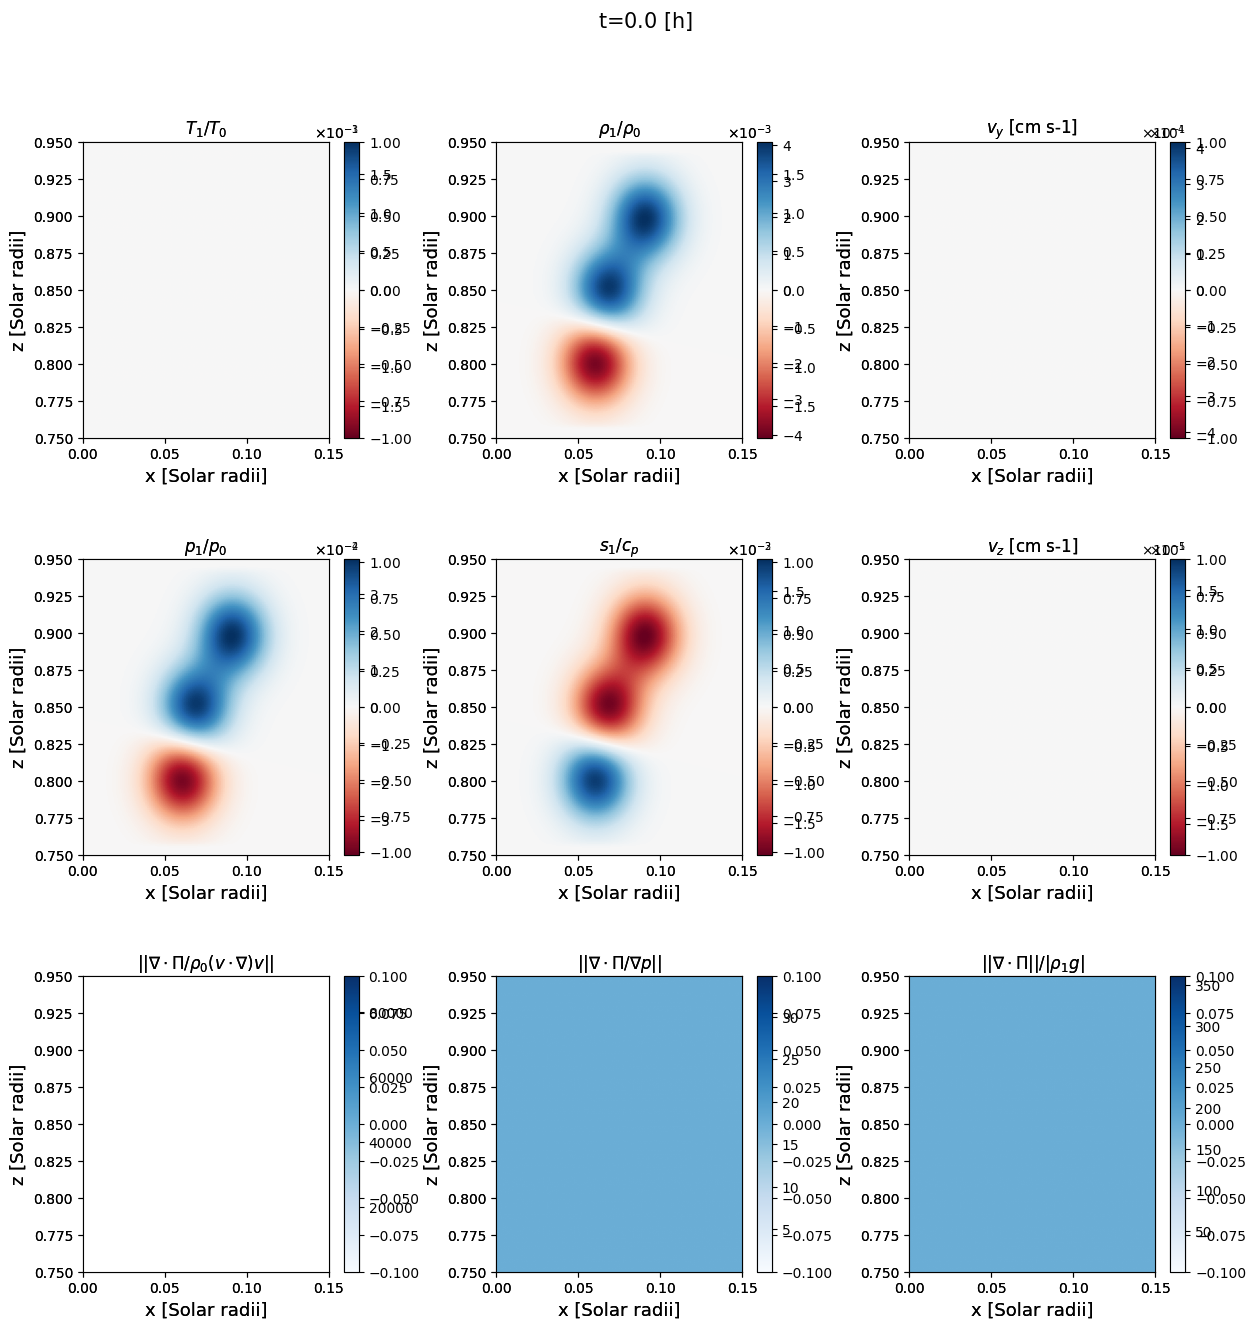

In [186]:
SAVE_FOLDER = 'data/'
RUN_NAME = "meeting_bubbles_conv_stable_3/"
SAVE_NAME = SAVE_FOLDER+RUN_NAME+"diffusion.mp4"

animate_all_diffusion_and_foreground_2D(DATA_FOLDER+RUN_NAME, save=True, save_name=SAVE_NAME, fps=20, save_interval=40, **{'normalize':True, 'quiver_on':True, 't_scale':u.h})

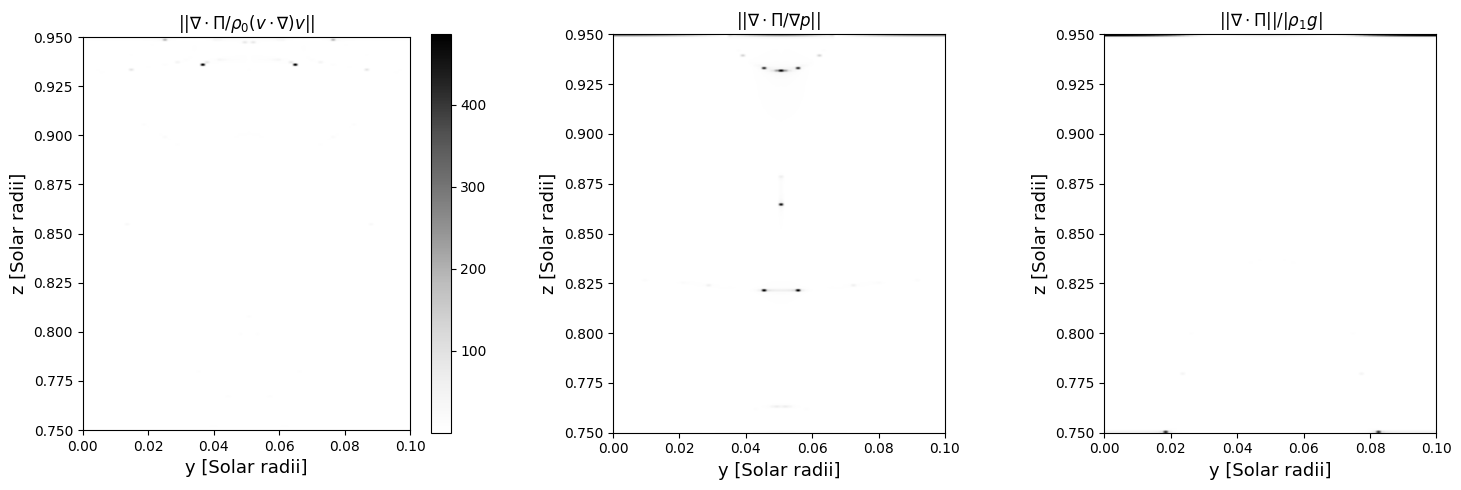

In [162]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_diffusion_term_2D(DATA_FOLDER+'meeting_bubbles/', ax[0], ax[1], ax[2], 10)
fig.tight_layout()

/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


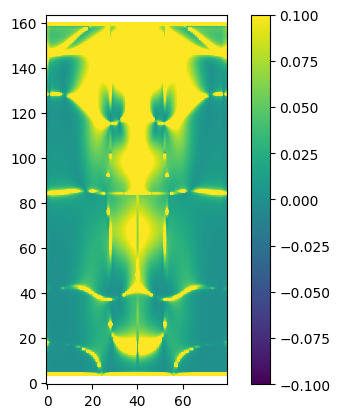

In [92]:
snap = 10

p1, unit, t = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "p1")
p1 = p1 * u.Unit(unit)
vz, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vz")
vz = vz * u.Unit(unit)
vy, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "vy")
vy = vy * u.Unit(unit)
rho1, unit, _ = get_foreground_variable(DATA_FOLDER+RUN_NAME, snap, "rho1")
rho1 = rho1 * u.Unit(unit)
g, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "g")
g = g * u.Unit(unit)
rho0, unit = get_background_variable(DATA_FOLDER+RUN_NAME, "rho0")
rho0 = rho0 * u.Unit(unit)

v = np.stack((vz, vy), axis=0)
_, _, grid_info_dict = get_info(DATA_FOLDER+RUN_NAME)

# plotting gradient of vz
dz, unit = grid_info_dict['dz']
dz = dz * u.Unit(unit)
dy, unit = grid_info_dict['dy']
dy = dy * u.Unit(unit)

grad_p1_term =   1/rho0[:,np.newaxis] * compute_gradient(p1, dz, dy)
advective_term = compute_advective_term(v, dz, dy)
diffusive_term = 1/rho0[:,np.newaxis] * compute_diffusive_term(v, dz, dy, compute_mu(v, dz, dy))
gravity_term_z =  rho1  * (g/rho0)[:,np.newaxis]
gravity_term_y =  np.zeros_like(gravity_term_z)

gravity_term = np.stack((gravity_term_z, gravity_term_y), axis=0)

diffusion_over_advection = diffusive_term / advective_term
diffusion_over_pressure = diffusive_term / grad_p1_term
diffusion_over_gravity = diffusive_term / gravity_term

vmax = np.max(np.abs(diffusion_over_advection))
vmin = -vmax

plt.imshow(norm(diffusion_over_advection), origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()

/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


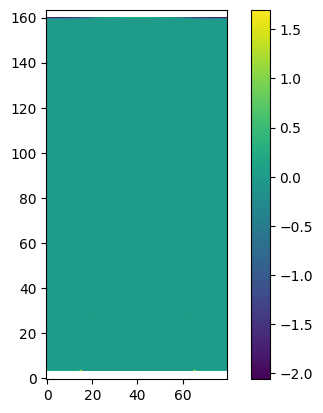

In [61]:
RUN_NAME = "meeting_bubbles/"

#plt.imshow(gravity_term_z.value, origin='lower')
plt.colorbar()

#plt.imshow(v[0], origin='lower')

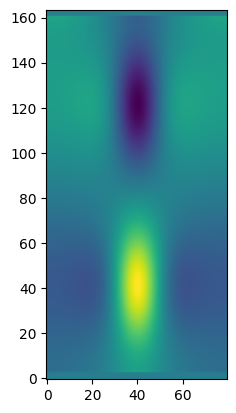

In [21]:
plt.imshow(v[0].value+grad_p1[0].value, origin='lower')

In [ ]:
def divergence(v, dz, dy):
    return np.gradient(v, dz, dy, axis=(0, 1))


Mht til tuning så vil jeg gjerne ha du tar med 3 bilder i din film (som den du presis sendte), hvor du har diffusionsledet divideret med adveksjonsledet (u\cdot nabla u) i første panel, diffusionsledet divideret med Trykk ledet (OMEGA_0 nabla(omega/OMEGA_0) i andre panel og til sist diffusionsledet delt med gravitasjonsledet i siste panel.





4:21
Se ledene i ligning 22 i Brown et al 2012 - Du må såklart bruke presis den måten de er skrevet i din kode - det er for å få forholdet mellem de forskjellige ledene så vi kan se hvilket led er viktigt hvor - gjir det mening?